# COEXIST Multi-Generational COVID Model

In [1]:
using AlgebraicPetri

using LabelledArrays
using OrdinaryDiffEq
using Plots
using JSON

using Catlab
using Catlab.CategoricalAlgebra
using Catlab.Graphics
using Catlab.Programs
using Catlab.Theories
using Catlab.WiringDiagrams
using Catlab.Graphics.Graphviz: run_graphviz

display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>"1"));
save_fig(g, fname::AbstractString, format::AbstractString) = begin
    open(string(fname, ".", format), "w") do io
        run_graphviz(io, g, format=format)
    end
end

save_fig (generic function with 1 method)

Define helper functions for defining the two types of
reactions in an epidemiology Model. Either a state
spontaneously changes, or one state causes another to change

In [2]:
ob(x::Symbol,n::Int) = codom(Open([x], LabelledReactionNet{Number,Int}(x=>n), [x])).ob;
function spontaneous_petri(transition::Symbol, rate::Number,
                           s::Symbol, s₀::Int,
                           t::Symbol, t₀::Int)
    Open(LabelledReactionNet{Number,Int}(unique((s=>s₀,t=>t₀)), (transition,rate)=>(s=>t)))
end;
function exposure_petri(transition::Symbol, rate::Number,
                        s::Symbol, s₀::Int,
                        e::Symbol, e₀::Int,
                        t::Symbol, t₀::Int)
    Open(LabelledReactionNet{Number,Int}(unique((s=>s₀,e=>e₀,t=>t₀)), (transition,rate)=>((s,e)=>(t,e))))
end;

Set arrays of initial conditions and rates to use in functor

In [3]:
pop = [8044056, 7642473, 8558707, 9295024,8604251,9173465,7286777,5830635,3450616] .- (4*1000);
N = sum(pop) + length(pop)*4*1000;
social_mixing_rate =
  [[5.10316562022642,1.28725377551533,1.30332531065247,2.31497083312315,1.1221598200343,0.606327539457772,0.453266757158743,0.177712174722219,0.0111726265254263],
   [1.15949254996891,8.00118824220649,1.24977685411394,1.51298690806342,1.88877951844257,0.835804485358679,0.431371281973645,0.343104864504218,0.0324429672946592],
   [1.19314902456243,1.2701954426234,3.55182053724384,1.81286158254244,1.80561825747571,1.29108026766182,0.708613434860661,0.248559044477893,0.0215323291988856],
   [1.83125260045684,1.32872195974583,1.56648238384012,2.75491288061819,1.94613663227464,1.2348814962672,0.863177586322153,0.244623623638873,0.0394364256673532],
   [0.910395333788561,1.7011898591446,1.60014517035071,1.99593275526656,2.90894801031624,1.37683234043657,0.859519958701156,0.488960115017174,0.110509077357166],
   [0.56560186656657,0.865574490657954,1.31557291022074,1.45621698394508,1.58310342861768,1.92835669973181,0.963568493650797,0.463041280007004,0.183483677017087],
   [0.544954016221808,0.575775829452094,0.930622416907882,1.31190809759635,1.27375718214796,1.24189546255302,1.32825334016313,0.66235513907445,0.0946971569608397],
   [0.319717318035767,0.68528632728864,0.488468642570909,0.556345582530282,1.08429412751444,0.893028152305907,0.991137484161889,1.17651345255182,0.12964732712923],
   [0.201086389216809,0.648252461859761,0.423327560644352,0.897268061280577,2.4516024037254,3.54014694719397,1.41761515077768,1.29700599099082,1.0189817510854]];

fatality_rate = [0.00856164, 0.03768844, 0.02321319, 0.04282494, 0.07512237, 0.12550367, 0.167096  , 0.37953452, 0.45757006];

Define an `oapply` function that connects the building block Petri nets to
the operations we will use in the model.

In [4]:
F(ex, n) = oapply(ex, Dict(
    :exposure=>exposure_petri(Symbol(:exp_, n), 1*social_mixing_rate[n][n]/pop[n], Symbol(:S,n), pop[n], Symbol(:I,n), 1000, Symbol(:E,n), 1000),
    :exposure_e=>exposure_petri(Symbol(:exp_e, n), .01*social_mixing_rate[n][n]/pop[n], Symbol(:S,n), pop[n], Symbol(:E,n),1000, Symbol(:E,n),1000),
    :exposure_i2=>exposure_petri(Symbol(:exp_i2, n), 6*social_mixing_rate[n][n]/pop[n], Symbol(:S,n), pop[n], Symbol(:I2,n), 1000, Symbol(:E,n),1000),
    :exposure_a=>exposure_petri(Symbol(:exp_a, n), 5*social_mixing_rate[n][n]/pop[n], Symbol(:S,n), pop[n], Symbol(:A,n),1000, Symbol(:E,n),1000),
    :progression=>spontaneous_petri(Symbol(:prog_, n), .25, Symbol(:I,n), 1000, Symbol(:I2,n), 1000),
    :asymptomatic_infection=>spontaneous_petri(Symbol(:asymp_, n), .86/.14*.2, Symbol(:E,n), 1000, Symbol(:A,n), 1000),
    :illness=>spontaneous_petri(Symbol(:ill_, n), .2, Symbol(:E,n), 1000, Symbol(:I,n), 1000),
    :asymptomatic_recovery=>spontaneous_petri(Symbol(:arec_, n), 1/15, Symbol(:A,n), 1000, Symbol(:R,n), 0),
    :recovery=>spontaneous_petri(Symbol(:rec_, n), 1/6, Symbol(:I2,n), 1000, Symbol(:R,n), 0),
    :recover_late=>spontaneous_petri(Symbol(:rec2_, n), 1/15, Symbol(:R,n), 0, Symbol(:R2,n), 0),
    :death=>spontaneous_petri(Symbol(:death2_, n), (1/15)*(fatality_rate[n]/(1-fatality_rate[n])), Symbol(:I2,n), 1000, Symbol(:D,n), 0)));

Define the COEXIST model using the `@relation` macro

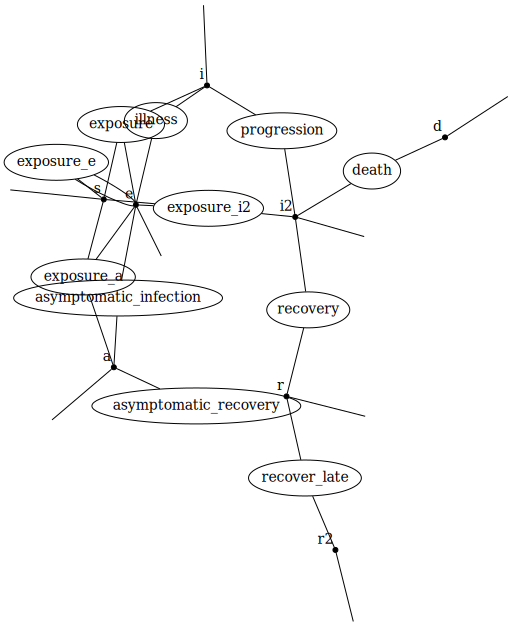

In [5]:
coexist = @relation (s, e, i, i2, a, r, r2, d) begin
    exposure(s, i, e)
    exposure_i2(s, i2, e)
    exposure_a(s, a, e)
    exposure_e(s, e, e)
    asymptomatic_infection(e, a)
    asymptomatic_recovery(a, r)
    illness(e, i)
    progression(i, i2)
    death(i2, d)
    recovery(i2, r)
    recover_late(r, r2)
end;
display_uwd(coexist)

Define an `oapply` function that can be used to create a model of
cross exposure between two sets of populations

In [6]:
F_cx(ex, x,y) = oapply(ex, Dict(
    :exposure=>exposure_petri(Symbol(:exp_, x,y), 1*social_mixing_rate[x][y]/(pop[x]+pop[y]), Symbol(:S,x), pop[x], Symbol(:I,y), 1000, Symbol(:E,x), 1000),
    :exposure_e=>exposure_petri(Symbol(:exp_e, x,y), .01*social_mixing_rate[x][y]/(pop[x]+pop[y]), Symbol(:S,x), pop[x], Symbol(:E,y),1000, Symbol(:E,x),1000),
    :exposure_a=>exposure_petri(Symbol(:exp_a, x,y), 5*social_mixing_rate[x][y]/(pop[x]+pop[y]), Symbol(:S,x), pop[x], Symbol(:A,y),1000, Symbol(:E,x),1000),
    :exposure_i2=>exposure_petri(Symbol(:exp_i2, x,y), 6*social_mixing_rate[x][y]/(pop[x]+pop[y]), Symbol(:S,x), pop[x], Symbol(:I2,y), 1000, Symbol(:E,x),1000),
    :exposure′=>exposure_petri(Symbol(:exp_, y,x), 1*social_mixing_rate[y][x]/(pop[x]+pop[y]), Symbol(:S,y), pop[y], Symbol(:I,x), 1000, Symbol(:E,y), 1000),
    :exposure_e′=>exposure_petri(Symbol(:exp_e, y,x), .01*social_mixing_rate[y][x]/(pop[x]+pop[y]), Symbol(:S,y), pop[y], Symbol(:E,x),1000, Symbol(:E,y),1000),
    :exposure_a′=>exposure_petri(Symbol(:exp_a, y,x), 5*social_mixing_rate[y][x]/(pop[x]+pop[y]), Symbol(:S,y), pop[y], Symbol(:A,x),1000, Symbol(:E,y),1000),
    :exposure_i2′=>exposure_petri(Symbol(:exp_i2, y,x), 6*social_mixing_rate[y][x]/(pop[x]+pop[y]), Symbol(:S,y), pop[y], Symbol(:I2,x), 1000, Symbol(:E,y),1000)
  ),
  Dict(
    :s=>ob(Symbol(:S, x), pop[x]),
    :e=>ob(Symbol(:E, x), 1000),
    :a=>ob(Symbol(:A, x), 1000),
    :i=>ob(Symbol(:I, x), 1000),
    :i2=>ob(Symbol(:I2, x), 1000),
    :r=>ob(Symbol(:R, x), 0),
    :r2=>ob(Symbol(:R2, x), 0),
    :d=>ob(Symbol(:D, x), 0),
    :s′=>ob(Symbol(:S, y), pop[y]),
    :e′=>ob(Symbol(:E, y), 1000),
    :a′=>ob(Symbol(:A, y), 1000),
    :i′=>ob(Symbol(:I, y), 1000),
    :i2′=>ob(Symbol(:I2, y), 1000),
    :r′=>ob(Symbol(:R, y), 0),
    :r2′=>ob(Symbol(:R2, y), 0),
    :d′=>ob(Symbol(:D, y), 0)
  ));

Use this new presentation to define a model
of cross exposure between two populations

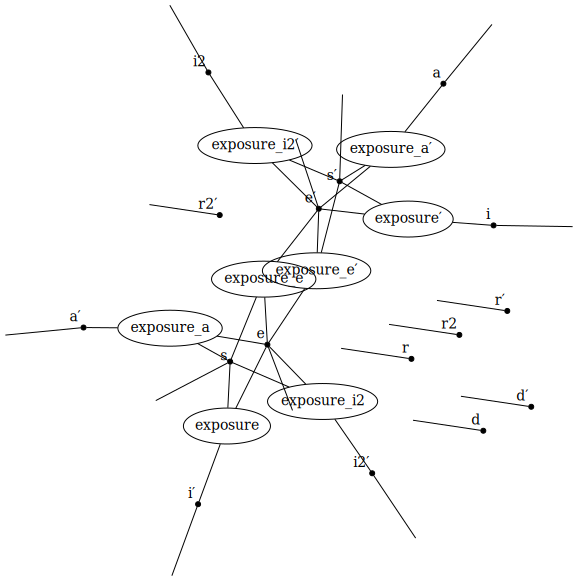

In [7]:
crossexposure = @relation (s, e, i, i2, a, r, r2, d, s′, e′, i′, i2′, a′, r′, r2′, d′) begin
    exposure(s, i′, e)
    exposure_i2(s, i2′, e)
    exposure_a(s, a′, e)
    exposure_e(s, e′, e)
    exposure′(s′, i, e′)
    exposure_i2′(s′, i2, e′)
    exposure_a′(s′, a, e′)
    exposure_e′(s′, e, e′)
end;
display_uwd(crossexposure)

To combine these two models, we need to create a final relational model and
use the `bundle_legs` function in our `oapply` that enables us to model 3
population wires instead of each individual state as a wire. Each of these
populations has their own COEXIST model, and interact through cross exposure

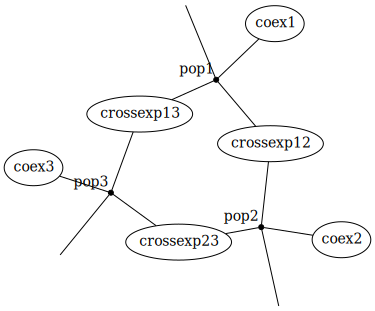

In [8]:
bundled_cross(x,y) = bundle_legs(F_cx(crossexposure, x, y), [tuple([1:8;]...), tuple([9:16;]...)])
bundled_coex(x) = bundle_legs(F(coexist, x), [tuple([1:8;]...)])
F_tcx(ex) = oapply(ex, Dict(
    :crossexp12=>bundled_cross(3,4),
    :crossexp13=>bundled_cross(3,5),
    :crossexp23=>bundled_cross(4,5),
    :coex1=>bundled_coex(3),
    :coex2=>bundled_coex(4),
    :coex3=>bundled_coex(5)));

threeNCoexist = @relation (pop1, pop2, pop3) begin
    crossexp12(pop1, pop2)
    crossexp13(pop1, pop3)
    crossexp23(pop2, pop3)
    coex1(pop1)
    coex2(pop2)
    coex3(pop3)
end;
display_uwd(threeNCoexist)

In [9]:
threeNCoexist_algpetri = apex(F_tcx(threeNCoexist))
Graph(threeNCoexist_algpetri);
save_fig(Graph(threeNCoexist_algpetri), "3ncoexist_petri", "svg"); # hide

![3-generation COEXIST model petri net](3ncoexist_petri.svg)

We can JSON to convert this Petri net into an
easily shareable format

In [10]:
JSON.print(threeNCoexist_algpetri.tables)

{"T":[{"rate":1.0158516804620892e-7,"tname":"exp_34"},{"rate":6.095110082772535e-7,"tname":"exp_i234"},{"rate":5.079258402310445e-7,"tname":"exp_a34"},{"rate":1.0158516804620891e-9,"tname":"exp_e34"},{"rate":8.777910996417687e-8,"tname":"exp_43"},{"rate":5.266746597850612e-7,"tname":"exp_i243"},{"rate":4.3889554982088435e-7,"tname":"exp_a43"},{"rate":8.777910996417687e-10,"tname":"exp_e43"},{"rate":1.052534350405119e-7,"tname":"exp_35"},{"rate":6.315206102430715e-7,"tname":"exp_i235"},{"rate":5.262671752025595e-7,"tname":"exp_a35"},{"rate":1.052534350405119e-9,"tname":"exp_e35"},{"rate":9.327595965846783e-8,"tname":"exp_53"},{"rate":5.596557579508069e-7,"tname":"exp_i253"},{"rate":4.6637979829233916e-7,"tname":"exp_a53"},{"rate":9.327595965846782e-10,"tname":"exp_e53"},{"rate":1.0877573746279346e-7,"tname":"exp_45"},{"rate":6.526544247767608e-7,"tname":"exp_i245"},{"rate":5.438786873139672e-7,"tname":"exp_a45"},{"rate":1.0877573746279345e-9,"tname":"exp_e45"},{"rate":1.1155900042152166

We can now easily generate a solver for DifferentialEquations.jl
because we encoded the intitial parameters and rates throughout
the construction of the model, the final result knows its
concentrations and rates.

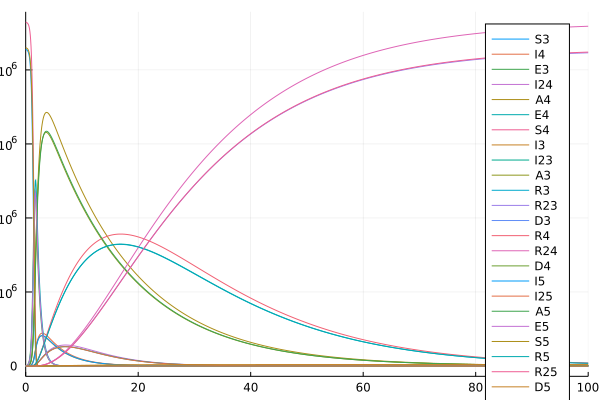

In [11]:
tspan = (0.0,100.0);
prob = ODEProblem(vectorfield(threeNCoexist_algpetri),concentrations(threeNCoexist_algpetri),tspan,rates(threeNCoexist_algpetri));
sol = solve(prob,Tsit5());
plot(sol, xlabel="Time", ylabel="Number of people")

If we want to model other intervention methods,
we can simply adjust the rates of exposure to
represent stay at home orders and mask wearing.
Because of how we have defined our rates, we can
simply update the social mixing rates, and
resolve the model.

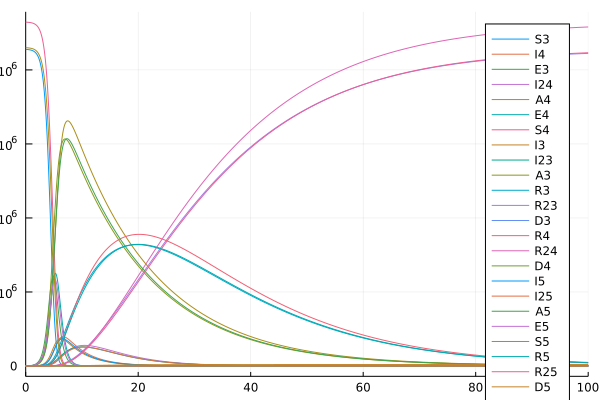

In [12]:
for i in 1:length(social_mixing_rate)
  for j in 1:length(social_mixing_rate[1])
    social_mixing_rate[i][j] = social_mixing_rate[i][j] / (i != j ? 10 : 5);
  end
end
threeNCoexist_algpetri = apex(F_tcx(threeNCoexist));

prob = ODEProblem(vectorfield(threeNCoexist_algpetri),concentrations(threeNCoexist_algpetri),tspan,rates(threeNCoexist_algpetri));
sol = solve(prob,Tsit5());
plot(sol, xlabel="Time", ylabel="Number of people")